# Tutorial: Vine-copulas with *pyvinecopulib*

In this tutorial, we will introduce you to the software pyvinecopulib (Nagler et al., 2022) to use vine-copulas. Here you can find the complete [documentation](https://vinecopulib.github.io/pyvinecopulib/).

In [ ]:
import micropip
await micropip.install("../packages/pyvinecopulib-0.6.8-cp310-cp310-win_amd64.whl")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvinecopulib as pv
import seaborn as sns
from scipy import stats
from py_banshee.copula_test import cvm_statistic
from scipy.interpolate import interp1d

%matplotlib inline 

/Users/pmaresnasarre/opt/anaconda3/envs/multi_more/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### 1. Loading and exploring the data

First, we load the data. Note that the code is prepared for the data file to be in the same directory as your notebook. If not, you will have to add the directory yourself.

In [2]:
data = pd.read_csv('dataset.csv', sep = ',')
data.head() #shows the first 5 rows of the data set

,Hs (m),Tm (s),Tp (s),W (ms-1)
0,0.47,4.47,5.92,2.1
1,0.45,4.49,5.85,2.2
2,0.43,4.49,5.78,1.9
3,0.42,4.49,5.71,2.0
4,0.40,4.47,5.65,2.3


In [3]:
data.shape

(299, 4)

We have imported a DataFrame with 4 columns and 299 rows. We have the following variables:
- Hs(m): significant wave height in m;
- Tm(s): mean wave period in s;
- Tp(s): peak wave period in s;
- W(ms-1): wind speed in m/s.

Similar to the first parts of the analysis to implement NPBN, we need to have a look at the dependence between the random variables to see whether the assumption of Gaussian copula is reasonable (and thus, we can use NPBN as it is a simpler model) or is not (and then we need to use vine-copulas to account for the tail-dependence).

We will not show that part of the analysis in this tutorial as it was already covered [here](tut_NPBN).

### 2. Fitting vine-copulas using Dissman's algorithm

Dissman's algorithm is already implemented in the package and it just requires one line of code to look for the best model using it.

In [5]:
#Transform data to unity space
def unity(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    return u_hat

unity_data = unity(data)

#Fit using Dissman's
vine_model = pv.Vinecop(np.array(unity_data))

#Let's see how the structure looks
vine_model.matrix

array([[2, 1, 4, 4],
       [1, 4, 1, 0],
       [4, 2, 0, 0],
       [3, 0, 0, 0]], dtype=uint64)

In [6]:
#Let's see the fitted copulas and trees
print(vine_model)

<pyvinecopulib.Vinecop>
** Tree: 0
3,2 <-> TLL, parameters = [30x30 grid]
2,1 <-> TLL, parameters = [30x30 grid]
1,4 <-> TLL, parameters = [30x30 grid]
** Tree: 1
3,1 | 2 <-> TLL, parameters = [30x30 grid]
2,4 | 1 <-> BB8 90°, parameters =        8
0.634317
** Tree: 2
3,4 | 1,2 <-> TLL, parameters = [30x30 grid]



### 3. Fitting vine-copulas using Brute Force

Now, we will use te vine-copula catalog up to 8 nodes (CHIMERA, [Morales-Nápoles et al., 2023](https://doi.org/10.1038/s41597-023-02252-6)) to fit all the possible vine-copula structures and choose the one with the lowest Akaike Information Criterion. This is the method called Brute Force.

In [10]:
# first we import a function to extract the matrices from a files
from get_matrices import get_matrices

#Import matrices
matrices_4_nodes = get_matrices('./CHIMERA_4/', nodes=4)

We fit the 24 regular vines (matrices) to data. This cell can take some time to run.

In [9]:
#Define a dictionary to store all the models
myDictionary = {} 

#Fit all the models: we force to fit the matrix we provide. The algorithm will choose the best copulas according to AIC.
for i in range(len(matrices_4_nodes)):
    myDictionary.update({str(i): pv.Vinecop(np.array(unity_data), matrix=matrices_4_nodes[i].matrix)})

#Compute AIC for each model
vines_AIC = []
for keys in myDictionary:
    vines_AIC.append(myDictionary[keys].aic())

We can also assess the performance of Dissman's algorithm by seeing the percentile of the AIC that it realises in the distribution.

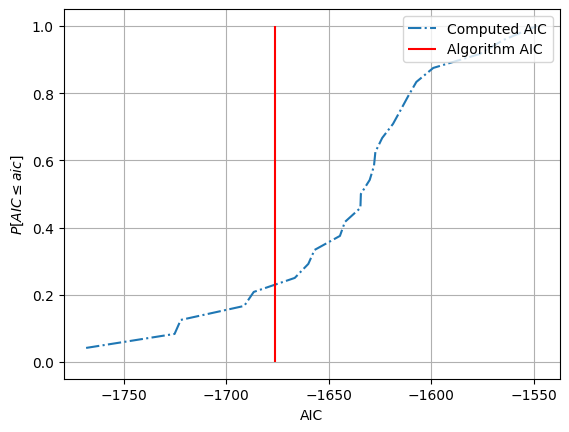

In [11]:
# Plotting the ECDF of the AIC of all the fitted vine-copulas and comparing it to the one obtained with Dissman's algorithm:

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

#compute the ecdf of the 24 AIC values
aic_ecdf = ecdf(vines_AIC)
#get the AIC of the algorithm 
algo_aic = vine_model.aic() 
#plot the velues, the vertical line represent the AIC computed by the algorithm. 
plt.plot(aic_ecdf[0],aic_ecdf[1],'-.',label= 'Computed AIC')
plt.vlines(algo_aic, 0,1, color='red', label= 'Algorithm AIC')
plt.xlabel('AIC')
plt.ylabel('${P[AIC \\leq aic]}$')
plt.grid()
plt.legend(loc=1)
plt.show()


### 4. Conditionalizing

When the dimensions increase, analytical conditionalization becomes more tricky as there is not stardard algorithm for it. Another option is to conditionalize through simulation. This is, you draw a very high number of random samples from the vine-copula and select those samples where the variable that we want to conditionalize on ($X_c$) takes values within the range we are interested on, for instance, $X_c < x_c$. We can then build the conditional distributions as the empirical ones from the selected samples.

Here, we will conditionalize the model given by Dissman's algorithm on a value of the wind speed os 10m/s.

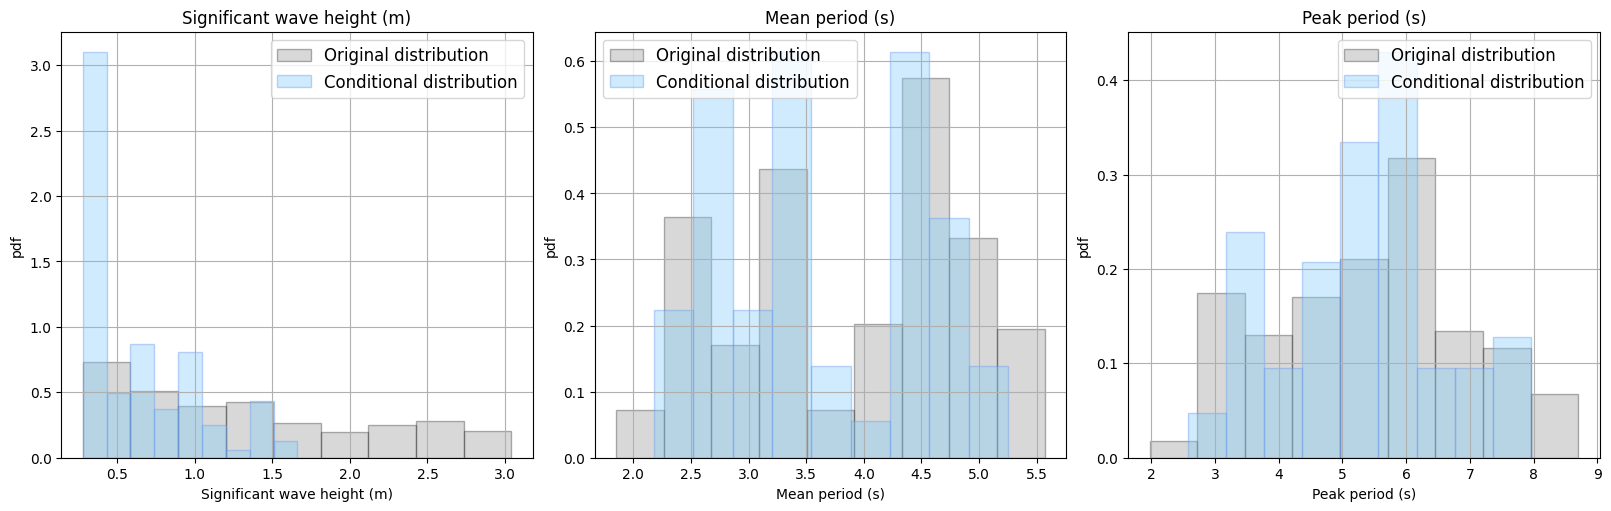

In [20]:
#%% Conditionalizing
def eval_ecdf(obs, x):
    interp_ecdf = interp1d(ecdf(obs)[0], ecdf(obs)[1], fill_value="extrapolate")
    return interp_ecdf(x)

def eval_inverse_ecdf(obs, x):
    ecdf_var = ecdf(obs)
    inverted_ecdf = interp1d(ecdf_var[1], ecdf_var[0], fill_value="extrapolate")
    return inverted_ecdf(x)

conditional_values = [3.5]
conditional_vars = 3

#Transform the conditionalizing value to unity space
conditional_unity_values = eval_ecdf(data.iloc[:, conditional_vars], conditional_values)

#Draw 1,000 random samples from the vine-copula
samples = vine_model.simulate(1000)

#Select those samples where the condition is fulfilled
selection = samples[np.where(samples[:, conditional_vars]<conditional_unity_values)[0],:]

#Transform them back to variable space using empiric margins
selection_non_unity = np.empty_like(selection)
selection_non_unity = [eval_inverse_ecdf(data.iloc[:,i], selection[:,i]) for i in range(selection.shape[1])]

#Plot them
fig, ax = plt.subplots(1, 3, figsize=(16, 5), layout = 'constrained')
ax[0].hist(data.iloc[:,0], density=True,
        edgecolor = 'k', facecolor = 'grey',alpha = 0.3,
        label = 'Original distribution', bins = 9)
ax[0].hist(selection_non_unity[0], density=True,
        edgecolor = 'cornflowerblue', facecolor = 'lightskyblue', alpha = 0.4, label = 'Conditional distribution',
        bins = 9)
ax[0].legend(fontsize="12")
ax[0].set_xlabel('Significant wave height (m)')
ax[0].set_ylabel('pdf')
ax[0].set_title('Significant wave height (m)')
ax[0].grid()

ax[1].hist(data.iloc[:,1], density=True,
        edgecolor = 'k', facecolor = 'grey',alpha = 0.3,
        label = 'Original distribution', bins = 9)
ax[1].hist(selection_non_unity[1], density=True,
        edgecolor = 'cornflowerblue', facecolor = 'lightskyblue', alpha = 0.4, label = 'Conditional distribution',
        bins = 9)
ax[1].legend(fontsize="12")
ax[1].set_xlabel('Mean period (s)')
ax[1].set_ylabel('pdf')
ax[1].set_title('Mean period (s)')
ax[1].grid()

ax[2].hist(data.iloc[:,2], density=True,
        edgecolor = 'k', facecolor = 'grey',alpha = 0.3,
        label = 'Original distribution', bins = 9)
ax[2].hist(selection_non_unity[2], density=True,
        edgecolor = 'cornflowerblue', facecolor = 'lightskyblue', alpha = 0.4, label = 'Conditional distribution',
        bins = 9)
ax[2].legend(fontsize="12")
ax[2].set_xlabel('Peak period (s)')
ax[2].set_ylabel('pdf')
ax[2].set_title('Peak period (s)')
ax[2].grid()

End of the tutorial.